In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train=pd.read_csv('train.tsv',delimiter='\t')

In [3]:
test=pd.read_csv('test.tsv',delimiter='\t')

In [4]:
test.head()

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,1,6,145.0,76.00,3160.0,19.6,81,2,volvo diesel
1,2,6,250.0,98.00,3525.0,19.0,77,1,ford granada
2,4,4,119.0,92.00,2434.0,15.0,80,3,datsun 510 hatchback
3,5,6,258.0,110.0,2962.0,13.5,71,1,amc hornet sportabout (sw)
4,6,4,97.0,88.00,2100.0,16.5,72,3,toyota corolla 1600 (sw)


In [5]:
df=train.append(test)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
df.tail()

,acceleration,car name,cylinders,displacement,horsepower,id,model year,mpg,origin,weight
194,14.0,audi 100ls,4,114.0,91.00,391,73,NaN,2,2582.0
195,14.4,dodge colt,4,156.0,105.0,392,80,NaN,1,2800.0
196,14.8,buick opel isuzu deluxe,4,111.0,80.00,393,77,NaN,1,2155.0
197,11.1,pontiac grand prix lj,8,400.0,180.0,394,77,NaN,1,4220.0
198,14.5,volkswagen rabbit custom,4,97.0,78.00,397,77,NaN,2,1940.0


In [7]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()

In [8]:
df['car name']=le.fit_transform(df['car name'])

In [9]:
df['horsepower']=df['horsepower'].replace('?',np.nan)

In [10]:
df['horsepower']=df['horsepower'].astype(np.float64)

In [11]:
df['horsepower']=df['horsepower'].fillna(df['horsepower'].median())

In [12]:
train_df=df[df['mpg'].notnull()]
test_df=df[df['mpg'].isnull()]

In [13]:
train_df.head()

,acceleration,car name,cylinders,displacement,horsepower,id,model year,mpg,origin,weight
0,16.0,96,4,135.0,84.0,0,82,29.0,1,2525.0
1,14.0,304,4,89.0,71.0,3,79,31.9,2,1925.0
2,15.5,276,6,156.0,108.0,9,76,19.0,3,2930.0
3,14.5,103,4,90.0,75.0,11,74,28.0,1,2125.0
4,17.3,278,4,89.0,62.0,13,81,37.7,3,2050.0


In [14]:
feats=[f for f in train_df.columns if f not in ['id','mpg']]

In [15]:
len(feats)

8

In [16]:
train_X=train_df[feats]
train_y=train_df['mpg']

In [17]:
import lightgbm as lgb

In [18]:
from sklearn.model_selection import KFold

In [19]:
folds=KFold(n_splits=10,shuffle=True,random_state=0)

In [20]:
folds.split(train_df[feats],train_df['mpg'])

<generator object _BaseKFold.split at 0x000000000BF0B518>

In [21]:
score=np.empty(10)
feature_importance_df = pd.DataFrame()
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats],train_df['mpg'])):
    train_X,train_y=train_df[feats].iloc[train_idx],train_df['mpg'].iloc[train_idx]
    valid_X,valid_y=train_df[feats].iloc[valid_idx],train_df['mpg'].iloc[valid_idx]

    params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective' : 'regression',
        'metric' : {'l2'},
        'num_leaves' : 31,
        'learning_rate' : 0.1,
        'feature_fraction' : 0.9,
        'bagging_fraction' : 0.8,
        'bagging_freq': 5,
        'verbose' : 0
    }
    
    lgb_train=lgb.Dataset(train_X,train_y)
    lgb_valid=lgb.Dataset(valid_X,valid_y)
    gbm=lgb.train(params,lgb_train,num_boost_round=100)
    pred_y=gbm.predict(valid_X)
    score[n_fold]=mean_absolute_error(pred_y,valid_y)
    
    gbm.feature_importance_

AttributeError: 'Booster' object has no attribute 'feature_importance_'

In [22]:
df.head()

,acceleration,car name,cylinders,displacement,horsepower,id,model year,mpg,origin,weight
0,16.0,96,4,135.0,84.0,0,82,29.0,1,2525.0
1,14.0,304,4,89.0,71.0,3,79,31.9,2,1925.0
2,15.5,276,6,156.0,108.0,9,76,19.0,3,2930.0
3,14.5,103,4,90.0,75.0,11,74,28.0,1,2125.0
4,17.3,278,4,89.0,62.0,13,81,37.7,3,2050.0


In [23]:
score=np.empty(10)
feature_importance_df = pd.DataFrame()
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats],train_df['mpg'])):
    train_X,train_y=train_df[feats].iloc[train_idx],train_df['mpg'].iloc[train_idx]
    valid_X,valid_y=train_df[feats].iloc[valid_idx],train_df['mpg'].iloc[valid_idx]
    
    gbm_reg=lgb.LGBMRegressor(objective='regression',
                         num_leaves=31,
                         n_estimators=100)
    gbm_reg.fit(train_X,train_y,
               verbose=0)
    pred_y=gbm_reg.predict(valid_X)
    score[n_fold]=mean_absolute_error(pred_y,valid_y)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = gbm_reg.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
score.mean()

2.3323244489245303

In [24]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

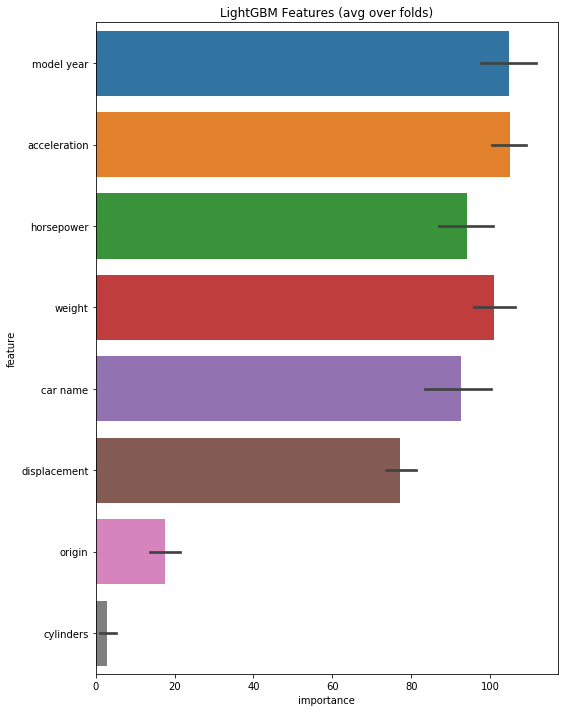

In [25]:
display_importances(feature_importance_df)

In [26]:
df_1=df.copy()

In [27]:
df_1['horsepower/weight']=df['horsepower']/df['weight']

In [28]:
df_1

,acceleration,car name,cylinders,displacement,horsepower,id,model year,mpg,origin,weight,horsepower/weight
0,16.0,96,4,135.0,84.0,0,82,29.0,1,2525.0,0.033267
1,14.0,304,4,89.0,71.0,3,79,31.9,2,1925.0,0.036883
2,15.5,276,6,156.0,108.0,9,76,19.0,3,2930.0,0.036860
3,14.5,103,4,90.0,75.0,11,74,28.0,1,2125.0,0.035294
4,17.3,278,4,89.0,62.0,13,81,37.7,3,2050.0,0.030244
5,18.0,248,4,151.0,90.0,16,82,27.0,1,2735.0,0.032907
6,18.5,41,6,250.0,105.0,18,75,16.0,1,3897.0,0.026944
7,11.0,204,8,350.0,180.0,19,73,11.0,1,3664.0,0.049127
8,12.5,22,4,121.0,113.0,23,70,26.0,2,2234.0,0.050582
9,15.2,120,8,318.0,135.0,24,79,18.2,1,3830.0,0.035248


In [29]:
train_df=df_1[df_1['mpg'].notnull()]
test_df=df_1[df_1['mpg'].isnull()]

feats=[f for f in train_df.columns if f not in ['id','mpg']]
train_X=train_df[feats]
train_y=train_df['mpg']

In [30]:
score=np.empty(10)
feature_importance_df = pd.DataFrame()
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats],train_df['mpg'])):
    train_X,train_y=train_df[feats].iloc[train_idx],train_df['mpg'].iloc[train_idx]
    valid_X,valid_y=train_df[feats].iloc[valid_idx],train_df['mpg'].iloc[valid_idx]
    
    gbm_reg=lgb.LGBMRegressor(objective='regression',
                         num_leaves=31,
                         n_estimators=100)
    gbm_reg.fit(train_X,train_y,
               verbose=0)
    pred_y=gbm_reg.predict(valid_X)
    score[n_fold]=mean_absolute_error(pred_y,valid_y)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = gbm_reg.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
score.mean()

2.322558599167686

In [31]:
score.mean()

2.322558599167686

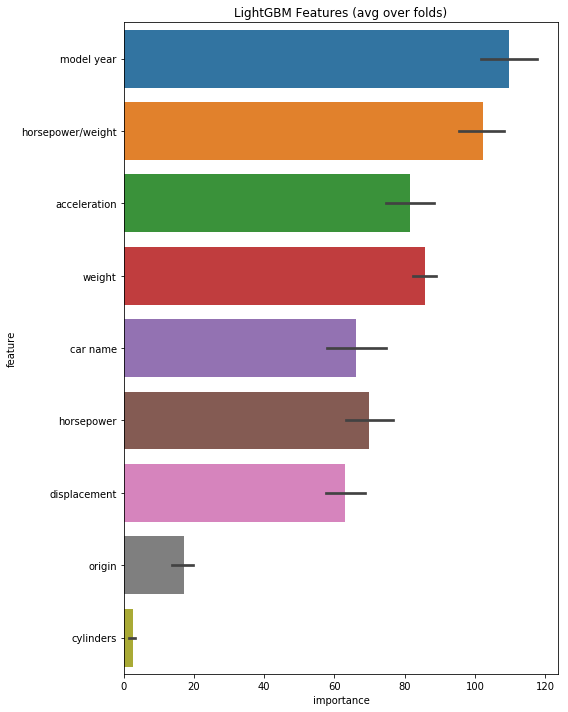

In [32]:
display_importances(feature_importance_df)

In [33]:
df.head(100)

,acceleration,car name,cylinders,displacement,horsepower,id,model year,mpg,origin,weight
0,16.0,96,4,135.0,84.0,0,82,29.0,1,2525.0
1,14.0,304,4,89.0,71.0,3,79,31.9,2,1925.0
2,15.5,276,6,156.0,108.0,9,76,19.0,3,2930.0
3,14.5,103,4,90.0,75.0,11,74,28.0,1,2125.0
4,17.3,278,4,89.0,62.0,13,81,37.7,3,2050.0
5,18.0,248,4,151.0,90.0,16,82,27.0,1,2735.0
6,18.5,41,6,250.0,105.0,18,75,16.0,1,3897.0
7,11.0,204,8,350.0,180.0,19,73,11.0,1,3664.0
8,12.5,22,4,121.0,113.0,23,70,26.0,2,2234.0
9,15.2,120,8,318.0,135.0,24,79,18.2,1,3830.0


In [34]:
train_df=df[df['mpg'].notnull()]
test_df=df[df['mpg'].isnull()]

feats=[f for f in train_df.columns if f not in ['id','mpg']]
train_X=train_df[feats]
train_y=train_df['mpg']

train_X,train_y=train_df[feats],train_df['mpg']
test_X=test_df[feats]
gbm_reg=lgb.LGBMRegressor(objective='regression',
                     num_leaves=31,
                     n_estimators=100)
gbm_reg.fit(train_X,train_y,
           verbose=0)
pred_sub=gbm_reg.predict(test_X)

In [35]:
sub=pd.DataFrame(test['id'])
sub['mpg']=pred_sub

In [36]:
sub.to_csv('0908_normal_sub.csv',header=False,index=False)